<a href="https://www.kaggle.com/code/isabelawhitaker/netflix-seasonality?scriptVersionId=174870256" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Does Season Affect Netflix Content?

<i>This project is an overview of how the season of the year affects Netflix content uploaded to the platform.</i>

## Objectives:

- Investigate when Netflix content is uploaded

- Consider whether the type of content uploaded changes depending on time of year

## About the Data:

This dataset is a csv file from [Kaggle](https://www.kaggle.com/datasets/shivamb/netflix-shows)

It is a comprehensive list of all the titles(TV Shows and Movies) available on netflix.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-shows/netflix_titles.csv


In [2]:
# import packages
import pandas as pd
df = pd.read_csv(r'/kaggle/input/netflix-shows/netflix_titles.csv')

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(palette='deep')

import numpy as np

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Inspecting the data

In [3]:
#Checking the head
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
#Checking the column names, they are logical, no need to rename
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [5]:
#Checking how many rows and columns
df.shape

(8807, 12)

In [6]:
#making a copy before changes are made
df1=df.copy()

# Cleansing the data

In [7]:
#converting the date_added column to datetime type for easier analysis
df1['date_added'] = pd.to_datetime(df1['date_added'].str.strip(), format='%B %d, %Y')

In [8]:
#Creating a numerical column for month added
df1['month_added'] = pd.to_datetime(df1['date_added']).dt.month
#Creating a numerical column for year added
df1['release_year'] = pd.to_datetime(df1['release_year'].astype(str), format='%Y')
#Creating a numerical column 'turnaround', showing different between year released and year launched on Netflix
df1['turnaround'] = df1['date_added'] - df1['release_year']

In [9]:
#lots of the country entries are combined lists of countries, that's why there are so many different rows
df1['country'].value_counts().sum()

7976

In [10]:
#Masking the data to create a df for each of the Top 5 countries
# make a mask for france in country
df1["fr"]= df1["country"].str.contains("France", na=False)
is_fr = df1["fr"]== True
msk_fr= df1[is_fr]

# make a mask for canada in country
df1["can"]= df1["country"].str.contains("Canada", na=False)
is_can = df1["can"]== True
msk_can= df1[is_can]

#make a mask for india in country
df1["ind"]= df1["country"].str.contains("India", na=False)
is_ind = df1["ind"]== True
msk_ind= df1[is_ind]

#make a mask for united states in country
df1["US"]= df1["country"].str.contains("United States", na=False)
is_us = df1["US"]== True
msk_us= df1[is_us]

#make a mask for uk in country
df1["UK"]= df1["country"].str.contains("United Kingdom", na=False)
is_uk = df1["UK"]== True
msk_uk= df1[is_uk]
#make a new df of the top 5 countries
msk_top5= pd.concat([msk_uk, msk_can, msk_us, msk_fr, msk_ind])
msk_top5.shape

(6380, 19)

In [11]:
#Create a function to find season
def find_season(x):
    
    if x == 12 or x==1 or x==2:
        return 'Winter'
    elif x == 3 or  x==4 or x==5:
        return 'Spring'
    elif x == 6 or x==7 or x==8:
        return 'Summer'
    elif x == 9 or x==10 or x==11:
        return 'Autumn'
    

#create a new column for season by applying the function
msk_top5['season'] =msk_top5['month_added'].apply(find_season)

In [12]:
# Finding out the number of titles added per season.
msk_top5['season'].value_counts()

season
Autumn    1684
Winter    1648
Summer    1539
Spring    1502
Name: count, dtype: int64

# Visualisations


In [13]:
drop_idxs = world["continent"].isin([
    "Antarctica",
    "Seven seas (open ocean)"
])

top5_names = [
    "India",
    "United States of America",
    "United Kingdom",
    "France",
    "Canada"]

countries = world[
    world["name"].isin(top5_names)
]


world_filtered = world[~drop_idxs]
top5_countries = world_filtered[world_filtered['name'].isin(top5_names)]
fig = px.choropleth(top5_countries,
                    locations='iso_a3',
                    color='name',
                    hover_name='name',
                    projection='natural earth',
                    title="Countries with the Most Netflix Content")

fig.update_geos(showcountries=True, countrycolor="black", showcoastlines=True)
# Remove the title from the legend
fig.update_layout(legend_title="")
fig.show()

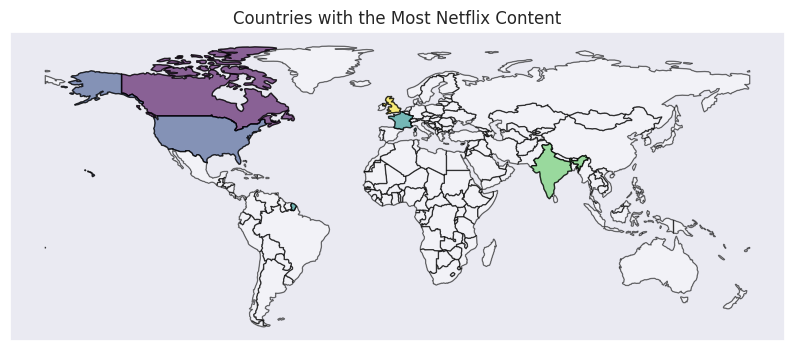

In [14]:
drop_continents = ["Antarctica", "Seven seas (open ocean)"]
world_filtered = world[~world["continent"].isin(drop_continents)]

top5_countries = world_filtered[world_filtered["name"].isin(top5_names)]

fig, ax = plt.subplots(figsize=(10, 5))
world_filtered.plot(ax=ax, color='white', edgecolor='black', alpha=0.4)
top5_countries.plot(ax=ax, cmap='viridis', edgecolor='black', alpha=0.6)
world_filtered.boundary.plot(ax=ax, color='black', linewidth=0.2)
ax.set_xticks([])
ax.set_yticks([])
plt.title("Countries with the Most Netflix Content")
plt.show()

### The Top 5 Countries

The first map is interactive and if you are unable to access, it can also be [viewed by clicking here](https://www.kaggle.com/code/isabelawhitaker/netflix-seasonality)

The maps above show the five countries with the most Netflix content:

-United States

-India

-United Kingdom

-Canada

-France

These country names occurred the most frequently in the 'Country' column of the dataset.


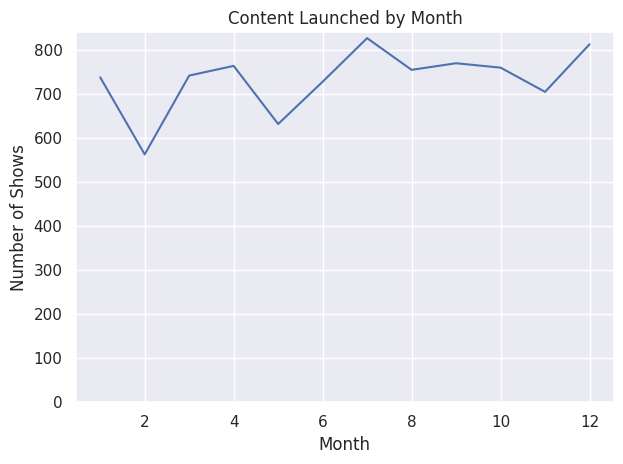

In [15]:
plt.figure()
content_fig= df1.groupby(['month_added'])['show_id'].count().plot(kind='line')
content_fig.set(title= 'Content Launched by Month', xlabel= 'Month', ylabel= 'Number of Shows')
plt.ylim(0)
plt.tight_layout()

### Netflix Content Launched by Month

The linechart above shows how the number of shows launched on the platform has changed by month.

Let's examine it from a seasonal perspective to see if any more general trends can be identified.

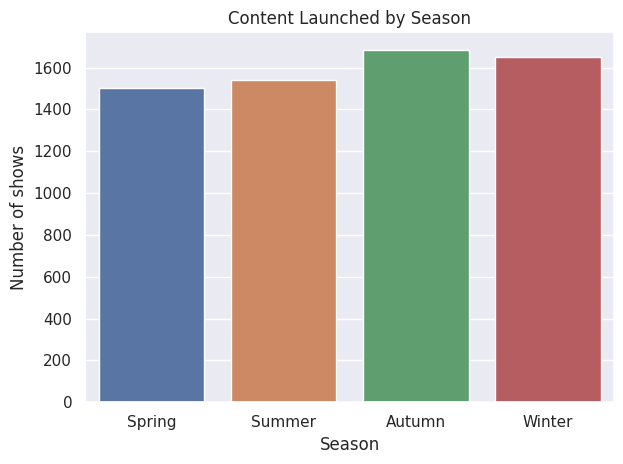

In [16]:
plt.figure()
sns_season_fig =sns.countplot(data=msk_top5, x='season', order=['Spring', 'Summer', 'Autumn', 'Winter'])
sns_season_fig.set(xlabel ="Season", ylabel = "Number of shows", title ='Content Launched by Season')
plt.tight_layout()
plt.show()

### Netflix Content Launched by Season

The barplot above shows that Netflix consistantly releases content each season of the year.

The amount of content released in Summer and Spring can be grouped into one category (as the values are almost the same), as can the amount of content released in Autumn and Winter.

Interestingly, there is a clear 10% increase of content released in Autumn and Winter.

This supplies the increase in demand, as people tend to watch more TV in Autumn and Winter.

But is this seasonal trend applicable to the type of content added to Netflix?

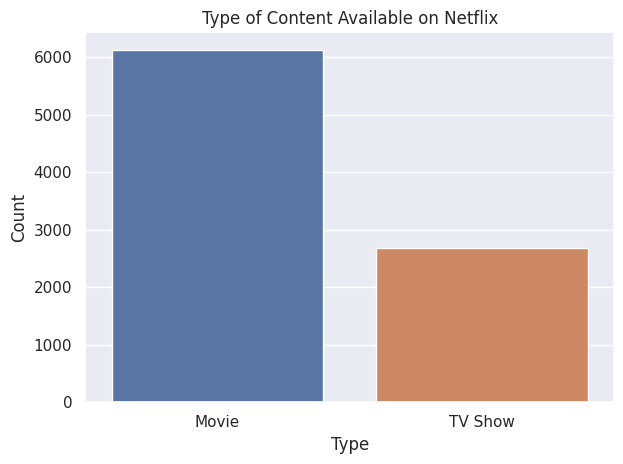

In [17]:
plt.figure()
type_fig = sns.countplot(data=df1, x='type')
type_fig.set(xlabel ="Type", ylabel = "Count", title ='Type of Content Available on Netflix')
plt.tight_layout()

### Types of Content Available on Netflix

The chart above shows Types of Netflix content on the dataframe. 

Netflix content can be divided into 2 types: TV shows and Movies.

Overall, there are 39% more movies than TV shows. 

[Text(0.5, 0, 'Type'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Type of Content Available in the Top 5 Countries')]

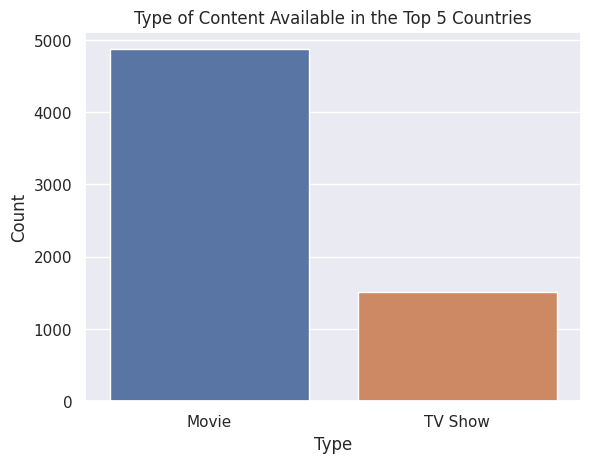

In [18]:
#in the top 5 countries
plt.figure()
top5_type_fig = sns.countplot(data=msk_top5, x='type')
top5_type_fig.set(xlabel ="Type", ylabel = "Count", title ='Type of Content Available in the Top 5 Countries')

### Types of content in the top 5 countries

The above chart shows that the ratio identified across the whole dataframe is also applicable to the Top 5 countries.

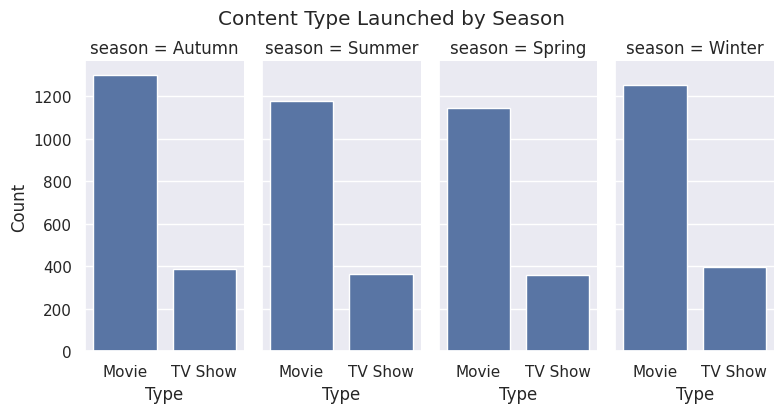

In [19]:
season_type_fig =  sns.FacetGrid(data= msk_top5, col = "season", 
                    height = 4, aspect  =.5)
season_type_fig.map(sns.countplot, "type", order = ['Movie', 'TV Show'],)
season_type_fig.fig.suptitle('Content Type Launched by Season', y=1.03)
season_type_fig.set(xlabel='Type', ylabel='Count')

### Content Type Launched by Season

The charts above show that the composition of the content launched side by side for each season. 

Surprisingly the ratio of TV shows to Movies launched stays consistent across the seasons!

The composition only differs by a maximum of 2% per season.


# Conclusion

-Netflix launch shows onto their platform consistently across the year. This allows them to stay fresh, relevant and talked about.

-In Autumn and Winter months, they increase the number of shows launched by 10%, this supplies the demand as people tend to watch more tv at this time.

-This pattern allows the platform to be fresh, consistent and supply the demand according to season.

-Netflix shows 40% more Movies than TV Shows at all times in a consistent ratio, it does not change depending on time of year. This maintains structural consistency of the brand and increases customer loyalty to the brand.
